In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt # Library to help us with plots
from sklearn.preprocessing import MinMaxScaler # Library to help us scale
from sklearn.model_selection import train_test_split # Library to help us split the dataset
from sklearn.ensemble import RandomForestClassifier # Library to enable Random Forest
from sklearn.svm import SVC # Library to enable support vector machine
from sklearn.neighbors import KNeighborsClassifier # Library to enable KNN
from sklearn.tree import DecisionTreeClassifier # Library to enable decision tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score ,roc_curve
from sklearn.model_selection import cross_validate, cross_val_score, KFold, StratifiedKFold, GridSearchCV
import pickle # Library to help us save the model

RANDOM_SEED = 1331
np.random.seed(RANDOM_SEED)

Based from the original Cuore project  by:
Frank Aiwuyor Ogiemwonyi, Rony Ventura, Tara de Groot,
Eric Vincent Rivas, Silvia Dubon, Dwi Aji Kurnia Putra, and Laureanne van Dijk 

## 1. Import DataFrame

In [2]:
df = pd.read_csv("processed.cleveland.csv",header=None) # Opening and reading the file of Cleveland
df.head() # View of first 5 rows 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [3]:
#Adding column names
#Column names referenced from original dataset
#https://archive.ics.uci.edu/dataset/45/heart+disease
df=df.set_axis(['Age', 'Sex', 'ChestPain', 'Trestbps', 'Chol', 'Fbs', 'Restecg', 'Thalach', 'Exang', 'Oldpeak', 'Slope', 'Ca', 'Thal', 'Class'], axis='columns')

In [4]:
#Check for null values and data types of each column
df.info()

print("\n\n" + " Data set shape is :")
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        303 non-null    float64
 1   Sex        303 non-null    float64
 2   ChestPain  303 non-null    float64
 3   Trestbps   303 non-null    float64
 4   Chol       303 non-null    float64
 5   Fbs        303 non-null    float64
 6   Restecg    303 non-null    float64
 7   Thalach    303 non-null    float64
 8   Exang      303 non-null    float64
 9   Oldpeak    303 non-null    float64
 10  Slope      303 non-null    float64
 11  Ca         303 non-null    object 
 12  Thal       303 non-null    object 
 13  Class      303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


 Data set shape is :


(303, 14)

In [5]:
#Distribution of the data to check for outliers especially on the age column 
df.describe()

,Age,Sex,ChestPain,Trestbps,Chol,Fbs,Restecg,Thalach,Exang,Oldpeak,Slope,Class
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


## 2. Preprocess the Dataset

### 2.1 Delete rows with missing values

In [6]:
# As Features "CA" and "THAL" are type object lets check what unique values they have 
print(df['Ca'].unique()) # Print unique values of "ca"
print(df['Thal'].unique()) # Print unique values of "thal"

['0.0' '3.0' '2.0' '1.0' '?']
['6.0' '3.0' '7.0' '?']


In [7]:
# Missing values are stated with a questionmark, so let's see how many missing values we have
print(" \"?\" values in the dataframe ") # Print the phrase "?" values in the dataframe
print((df == "?").sum(axis=0)) # Finding the number of "?" in each feature (column) and print the sum 

 "?" values in the dataframe 
Age          0
Sex          0
ChestPain    0
Trestbps     0
Chol         0
Fbs          0
Restecg      0
Thalach      0
Exang        0
Oldpeak      0
Slope        0
Ca           4
Thal         2
Class        0
dtype: int64


In [8]:
# Creating a new df in which the rows with values "?" from the columns "ca" and "thal" are excluded
df = df[(df["Ca"] != '?') & (df["Thal"] != '?')]#This line will use only the rows that does not contain ?
#In case we had empty values in the form of nan or null: 
#df.dropna(inplace = True) #  Deletion of null values 
print(" \"?\" values in the dataframe ") # Print the phrase "?" values in the dataframe
# Finding the number of "?" in each feature (column) and showing (printing) the sum of it to verify there are no more "?" values
print((df == "?").sum(axis=0)) 


 "?" values in the dataframe 
Age          0
Sex          0
ChestPain    0
Trestbps     0
Chol         0
Fbs          0
Restecg      0
Thalach      0
Exang        0
Oldpeak      0
Slope        0
Ca           0
Thal         0
Class        0
dtype: int64


In [9]:
df = df.reset_index(drop=True) # Reset the index to make sure the index matches the number of entries 
df.dtypes

Age          float64
Sex          float64
ChestPain    float64
Trestbps     float64
Chol         float64
Fbs          float64
Restecg      float64
Thalach      float64
Exang        float64
Oldpeak      float64
Slope        float64
Ca            object
Thal          object
Class          int64
dtype: object

### 2.2 Transform Data

In [10]:
#Create a copy of the dataframe to work in the machine learning model 
#The transformation of data is done in Python instead of PowerBi to ease up the reproducibility and demonstrate the procedure
dfmodel=df.copy()
dfmodel.head()

,Age,Sex,ChestPain,Trestbps,Chol,Fbs,Restecg,Thalach,Exang,Oldpeak,Slope,Ca,Thal,Class
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [11]:
#Now that the data is clean, we have to convert it to the correct datatype
df["Age"] = df["Age"].astype("int")
df["Sex"] = df["Sex"].astype("category")
df["ChestPain"] = df["ChestPain"].astype("category")
df["Fbs"] = df["Fbs"].astype("category")
df["Restecg"] = df["Restecg"].astype("category")
df["Thalach"] = df["Thalach"].astype("int")
df["Exang"] = df["Exang"].astype("category")
df["Slope"] = df["Slope"].astype("category")
df["Ca"] = pd.to_numeric(df['Ca'])
df["Ca"]=df["Ca"].astype("int")
df["Thal"] = pd.to_numeric(df['Thal'])
df["Thal"] = df["Thal"].astype("category")
df["Class"]=df["Class"].astype("category")
# Rename values 
df['Sex'] = df['Sex'].replace({0: 'Female', 1: 'Male'})
df['ChestPain'] = df['ChestPain'].replace({1: 'Typical angina', 2: 'Atypical angina',3:'Non-anginal pain',4:'Asymptomatic'})
df['Fbs'] = df['Fbs'].replace({0: 'Normal', 1: 'High'})
df['Restecg'] = df['Restecg'].replace({0: 'Normal', 1: 'Abnormal',2:'Probable hypertrophy'})
df['Exang'] = df['Exang'].replace({0: 'No', 1: 'Yes'})
df['Slope'] = df['Slope'].replace({1: 'Upsloping', 2: 'Flat',3:'Downsloping'})
df['Thal'] = df['Thal'].replace({3.0: 'Normal',6:'Fixed defect',7:'Reversable defect'})




C:\Users\rony_\AppData\Local\Temp\ipykernel_13264\4158199636.py:16: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['Sex'] = df['Sex'].replace({0: 'Female', 1: 'Male'})
C:\Users\rony_\AppData\Local\Temp\ipykernel_13264\4158199636.py:17: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['ChestPain'] = df['ChestPain'].replace({1: 'Typical angina', 2: 'Atypical angina',3:'Non-anginal pain',4:'Asymptomatic'})
C:\Users\rony_\AppData\Local\Temp\ipykernel_13264\4158199636.py:18: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype i

In [12]:
df.head()

,Age,Sex,ChestPain,Trestbps,Chol,Fbs,Restecg,Thalach,Exang,Oldpeak,Slope,Ca,Thal,Class
0,63,Male,Typical angina,145.0,233.0,High,Probable hypertrophy,150,No,2.3,Downsloping,0,Fixed defect,0
1,67,Male,Asymptomatic,160.0,286.0,Normal,Probable hypertrophy,108,Yes,1.5,Flat,3,Normal,2
2,67,Male,Asymptomatic,120.0,229.0,Normal,Probable hypertrophy,129,Yes,2.6,Flat,2,Reversable defect,1
3,37,Male,Non-anginal pain,130.0,250.0,Normal,Normal,187,No,3.5,Downsloping,0,Normal,0
4,41,Female,Atypical angina,130.0,204.0,Normal,Probable hypertrophy,172,No,1.4,Upsloping,0,Normal,0


In [13]:
df.shape # Size after deletion of missing values
#After the cleaning phase we have deleted 6 rows in total ,approximately 1.98%.

(297, 14)

### 2.3 Check Class labels


Class= 0: Healthy \
Class=> 1: Not *healthy* \
Prediction outcome will categorize  healthy or not healthy , therefore class 1,2,3,4 will be considered not healthy and grouped together in one single class

In [14]:
df["Class"].value_counts() # Count and show the number of values per class label


Class
0    160
1     54
2     35
3     35
4     13
Name: count, dtype: int64

In [15]:
# Changing values from 1-4 to 1, because 1 means they have a heart disease i.e. not healthy 
df["Class"].replace({2: 1, 3: 1, 4:1}, inplace=True) 
dfmodel["Class"].replace({2: 1, 3: 1, 4:1}, inplace=True)#replace the class labels in the models dataframe

C:\Users\rony_\AppData\Local\Temp\ipykernel_13264\2000051092.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Class"].replace({2: 1, 3: 1, 4:1}, inplace=True)
C:\Users\rony_\AppData\Local\Temp\ipykernel_13264\2000051092.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df["Class"].replace({2: 1, 3: 1, 4:1},

In [16]:
df["Class"].value_counts() # Count the amount of values for each class label 

Class
0    160
1    137
Name: count, dtype: int64

Important  * After joining the "not healthy" labels into a single one, the dataset is now more balanced * 

In [17]:
#Rename the values of Class column
df['Class'] = df['Class'].replace({0: 'Healthy', 1: 'Not Healthy'})
df.head()

C:\Users\rony_\AppData\Local\Temp\ipykernel_13264\886044704.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['Class'] = df['Class'].replace({0: 'Healthy', 1: 'Not Healthy'})


,Age,Sex,ChestPain,Trestbps,Chol,Fbs,Restecg,Thalach,Exang,Oldpeak,Slope,Ca,Thal,Class
0,63,Male,Typical angina,145.0,233.0,High,Probable hypertrophy,150,No,2.3,Downsloping,0,Fixed defect,Healthy
1,67,Male,Asymptomatic,160.0,286.0,Normal,Probable hypertrophy,108,Yes,1.5,Flat,3,Normal,Not Healthy
2,67,Male,Asymptomatic,120.0,229.0,Normal,Probable hypertrophy,129,Yes,2.6,Flat,2,Reversable defect,Not Healthy
3,37,Male,Non-anginal pain,130.0,250.0,Normal,Normal,187,No,3.5,Downsloping,0,Normal,Healthy
4,41,Female,Atypical angina,130.0,204.0,Normal,Probable hypertrophy,172,No,1.4,Upsloping,0,Normal,Healthy


### 2.4 Save the CSVs
Saving the csv files for reproducibility and use in PowerBi tool.

In [18]:
df.to_csv('Cleveland_TransformedData.csv', index=False)
dfmodel.to_csv('Cleveland_ModelData.csv', index=False)

## 3. Exploratory Data Analysis (EDA)

A small data analysis is performed in python just to grasp a notion of what is behind the data.
A dedicated data analysis is done in Power Bi

Comparison of women vs men 

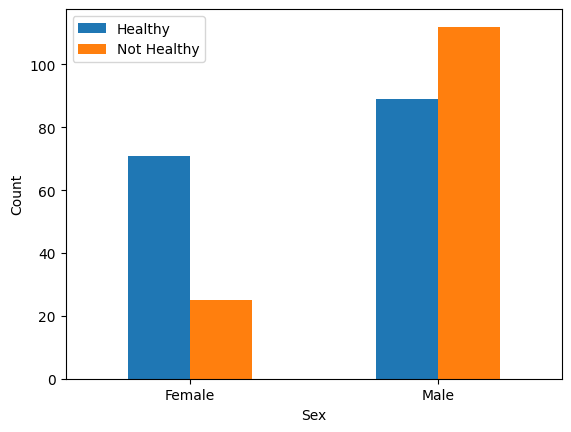

Sex  Class
0.0  0         71
     1         25
1.0  1        112
     0         89
Name: count, dtype: int64

In [19]:
# We are going to plot the negative and positive values (healthy/not healthy) grouped by sex.
# This way we can compare the outcomes between women and men.

ylabels = ['Healthy', 'Not Healthy']  # The labels we use for the legend
xlabels = ["Female", "Male"]  # The labels we use for the x-axis

positions = (0, 1)  # Positions for the bars in the plot

Sex = dfmodel.groupby("Sex")['Class'].value_counts()  # Grouping by sex and class
ax = Sex.unstack().plot(kind='bar', legend=False, rot=0)  # Creating the bar plot

plt.legend(labels=ylabels)  # Create the legend based on who is healthy/not healthy
plt.xticks(ticks=positions, labels=xlabels)  # Set the x-axis labels
plt.xlabel("Sex")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

plt.show()  # Show the plot
Sex  # Print the values we see in the plot to check the exact values

## 4. Standardization

In [20]:
# Define the columns in which the values are numerical 
numerical = ["Age", "Trestbps", "Chol", "Thalach", "Oldpeak", "Ca"]
X = dfmodel[numerical] # Create a dataframe for standardization that only includes the numerical features
# We compared the evaluation metrics of MinMaxScaler() and StandardScaler()
# MinMaxScaler() scored slightly better in model performance , so MinMaxScaler() is selected as default scaler
scaler=MinMaxScaler() # Standardize the dataset
df_standard = scaler.fit_transform(X) #fit and transform the data
# Create a dataframe with the standardized values
df_standard = pd.DataFrame(df_standard, columns=numerical) 

In [21]:
# Combine original dataframe with standardized dataset
standardized = dfmodel.copy() # Create a copy of the origional dataset
# Replace the numerical features in the original dataframe with the standardized features
standardized[numerical] = df_standard[numerical] 
standardized.head() # Print the first 5 rows of the standardized data

,Age,Sex,ChestPain,Trestbps,Chol,Fbs,Restecg,Thalach,Exang,Oldpeak,Slope,Ca,Thal,Class
0,0.708333,1.0,1.0,0.481132,0.244292,1.0,2.0,0.603053,0.0,0.370968,3.0,0.000000,6.0,0
1,0.791667,1.0,4.0,0.622642,0.365297,0.0,2.0,0.282443,1.0,0.241935,2.0,1.000000,3.0,1
2,0.791667,1.0,4.0,0.245283,0.235160,0.0,2.0,0.442748,1.0,0.419355,2.0,0.666667,7.0,1
3,0.166667,1.0,3.0,0.339623,0.283105,0.0,0.0,0.885496,0.0,0.564516,3.0,0.000000,3.0,0
4,0.250000,0.0,2.0,0.339623,0.178082,0.0,2.0,0.770992,0.0,0.225806,1.0,0.000000,3.0,0


## 5. Selecting the features

In [22]:
# Create  test set: one with all features 
# First we create a dataframe in which all features are included
X_features = standardized.copy() # Create a copy of the standardized dataframe
X_features.drop(columns=['Class'],inplace=True) # Drop the outcome variable
y = standardized['Class'] # We store the classlabels in y

## 6. Splitting in training and test sets

In [23]:
# Split the dataset that includes all features into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=RANDOM_SEED)


In [24]:
# Defining a method to print the size of the test/training set
def size(X_train, X_test, y_train, y_test):
  print("The size of the training set is: ",X_train.shape)
  print("The size of the test set is: ",X_test.shape)
  print("The size of the training target set is: ",y_train.shape)
  print("The size of the test target set is: ",y_test.shape)

In [25]:
# Checking if the train/split sets match with target of the dataset with all features
size(X_train, X_test, y_train, y_test)

The size of the training set is:  (237, 13)
The size of the test set is:  (60, 13)
The size of the training target set is:  (237,)
The size of the test target set is:  (60,)


## 7. Choosing models Random Forest, SVM, KNN, Descision Tree


In [26]:
# Define classifiers to train and test 
MODELS_TO_TEST = {
    "RF_15": RandomForestClassifier(n_estimators=15, max_depth=5),
    "SVM": SVC(kernel='linear'),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "DT": DecisionTreeClassifier(max_depth=5),
}

# Define the number of splits 
NUMBER_OF_SPLITS = 5

# Define the scoring metrics
SCORING_METRICS = ["accuracy", "precision_macro", "recall_macro", "f1_macro", "roc_auc"] # Metrics of interest

# Create empty DataFrame to populate the name of the classifier and the six values returned from `cross_validate()`
results_evaluation = pd.DataFrame({
                                    "classifier_name":[],
                                    "fit_time": [],
                                    "score_time": [],
                                    "test_accuracy": [],
                                    "test_precision_macro": [],
                                    "test_recall_macro": [],
                                    "test_f1_macro": [],
                                    "test_roc_auc": [],
                                    })
results_evaluation_selected_features = pd.DataFrame({
                                    "classifier_name":[],
                                    "fit_time": [],
                                    "score_time": [],
                                    "test_accuracy": [],
                                    "test_precision_macro": [],
                                    "test_recall_macro": [],
                                    "test_f1_macro": [],
                                    "test_roc_auc": [],
                                    })

## 8. Train, test and evaluation metrics

In [27]:
#### ITERATION FOR THE EXPERIMENT for Dataset with ALL features

for name, classifier in MODELS_TO_TEST.items():
    
    print(f"Currently training the classifier {name}.")

    # Get the evaluation metrics per fold after cross-validation
    # Note that we are passing the normalized array `data_X_norm` to all classifiers
    scores_cv = cross_validate(classifier, X_features, y, cv=NUMBER_OF_SPLITS, scoring=SCORING_METRICS)

    # Average the scores among folds
    dict_this_result = {
                    "classifier_name":[name],
                    }
    # Populate the dictionary with the results of the cross-validation
    for metric_name, score_per_fold in scores_cv.items():
        dict_this_result[metric_name] = [ scores_cv[metric_name].mean() ]

    # Generate the results to populate the pandas.DataFrame
    this_result = pd.DataFrame(dict_this_result)

    # Append to the main dataframe with the results 
    results_evaluation = pd.concat([results_evaluation, this_result], ignore_index=True)

print("The experimental setup has finished")

Currently training the classifier RF_15.
Currently training the classifier SVM.
Currently training the classifier KNN.
Currently training the classifier DT.
The experimental setup has finished


In [28]:
# Printing the evaluation metrics of all features
results_evaluation

,classifier_name,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,test_roc_auc
0,RF_15,0.036618,0.024258,0.814576,0.819936,0.809904,0.811140,0.893543
1,SVM,0.006600,0.018709,0.831412,0.835225,0.828158,0.829025,0.904101
2,KNN,0.002783,0.015315,0.811186,0.817881,0.808697,0.807979,0.868035
3,DT,0.002791,0.011702,0.740339,0.743360,0.734342,0.734502,0.746912


In [29]:
# Store the average accuracy from the all features dataset and group by the name of the classifier
average_score_classifier = results_evaluation.groupby(by=["classifier_name"]).mean()

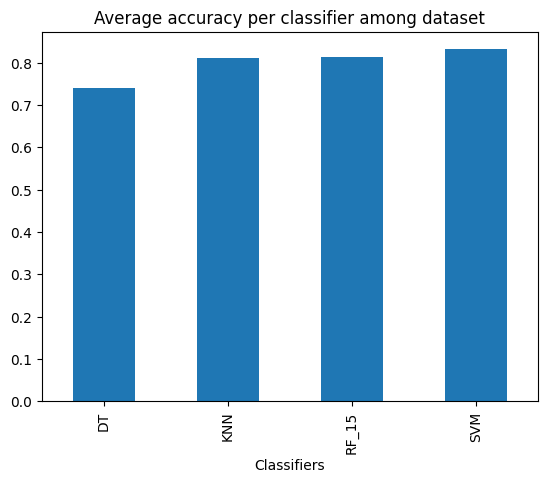

classifier_name
DT       0.740339
KNN      0.811186
RF_15    0.814576
SVM      0.831412
Name: test_accuracy, dtype: float64

In [30]:
average_score_classifier["test_accuracy"].plot.bar() # Plot the the average accuracy from the all features dataset
plt.title("Average accuracy per classifier among dataset") # Set a title for the plot
plt.xlabel("Classifiers") # Set a label for the X-axis
plt.show() # Show the plot
average_score_classifier["test_accuracy"]

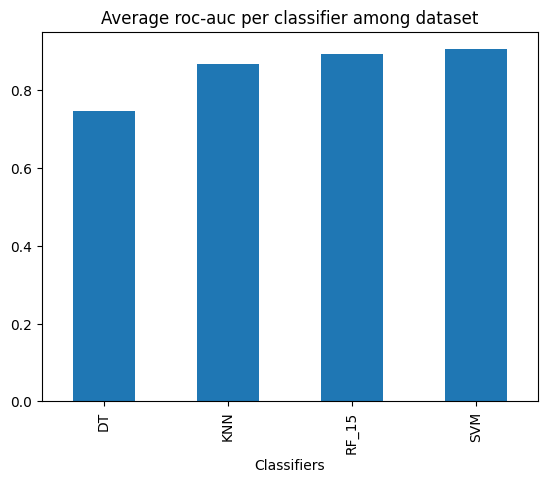

classifier_name
DT       0.746912
KNN      0.868035
RF_15    0.893543
SVM      0.904101
Name: test_roc_auc, dtype: float64

In [31]:
average_score_classifier["test_roc_auc"].plot.bar() # Plot the the average accuracy from the all features dataset
plt.title("Average roc-auc per classifier among dataset") # Set a title for the plot
plt.xlabel("Classifiers") # Set a label for the X-axis
plt.show() # Show the plot
average_score_classifier["test_roc_auc"]

## 9. Tune the models for better performance by optimizing the parameters




In [32]:
# Create a standard SVC classifier clf without any parameter
clf = SVC()
# Grid search with a list of two parameter dictionaries, one with kernel = ['poly'] and degree = [2, 3, 4]
# and the other one with kernel = ['linear', 'rbf'] and C = [1, 10, 100, 1000]
param_grid = [
    {'kernel': ['poly'], 'degree': [2, 3, 4]},
    {'kernel': ['linear', 'rbf'], 'C': [1, 10, 100, 1000]},
    ]
# Run GridSearch and save the scores
gs = GridSearchCV(clf, param_grid, cv=5)

In [33]:
# Fit the training data of the dataset with all features
gs.fit(X_train, y_train)
# The best classifier
gs.best_estimator_

SVC(kernel='poly')

In [34]:
# The best score
gs.best_score_

0.823049645390071

## 10. Saving the best model

In [35]:
# Predict model with gs (best model)
y_predicted = gs.predict(X_test)
print(classification_report(y_test, y_predicted))
print(f'model  AUC score: {roc_auc_score(y_test, y_predicted)}')

              precision    recall  f1-score   support

           0       0.85      0.82      0.84        28
           1       0.85      0.88      0.86        32

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60

model  AUC score: 0.8482142857142857


In [36]:
# Method for plotting AUC/ROC curve
def plot_roc_curve(true_y, y_prob): 
    
    fpr, tpr, thresholds = roc_curve(y_test, y_predicted)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

model  AUC score: 0.8482142857142857


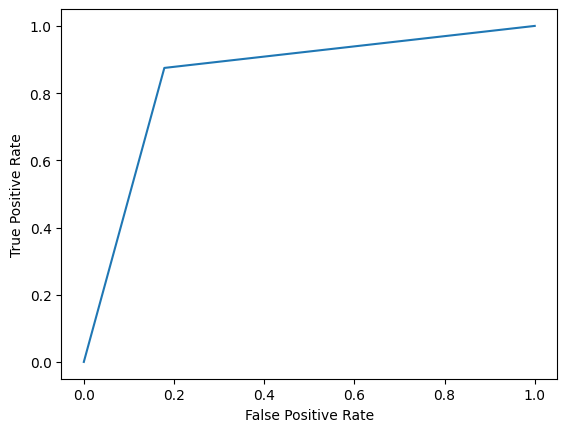

In [37]:
plot_roc_curve(y_test, y_predicted) # Plot AUC/ROC curve
print(f'model  AUC score: {roc_auc_score(y_test, y_predicted)}')

In [38]:
# Save the trained model into trained_model_cuore.pickle using pickle, without using a folder_path
FOLDER_PATH = ""
trained_model_filename = FOLDER_PATH + "trained_model_cuore.pickle"

In [39]:
# Create file with the specific variable in the specified folder
data_to_save = gs.best_estimator_ 
file_path = trained_model_filename


In [40]:
# Creates a binary object and writes the indicated variables
with open(file_path, "wb") as writeFile:
    pickle.dump(data_to_save, writeFile)

In [41]:
# Here we will load the same model, but in a variable that is completely empty
loaded_model = None

In [42]:
# Load model
with open(trained_model_filename, "rb") as readFile:
    loaded_model = pickle.load(readFile)

In [43]:
Y_predicted_loaded_model = loaded_model.predict(X_test) # Confirm that the loaded model has the same metrics as the one trained
print(classification_report(y_test, Y_predicted_loaded_model))
print(f'model  AUC score: {roc_auc_score(y_test, Y_predicted_loaded_model)}')

              precision    recall  f1-score   support

           0       0.85      0.82      0.84        28
           1       0.85      0.88      0.86        32

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60

model  AUC score: 0.8482142857142857
